# Autoencoder Digit Recognition

In [8]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Load MNIST Data (PyTorch Tensor)

In [16]:
train_set = MNIST('./data',train=True,download=True)
test_set = MNIST('./data',train=False,download=True)

### Split training set into training and validation

In [17]:
print(f'Training Data Shape: {train_set.data.shape}')
print(f'Training Labels: {train_set.targets.shape}')
print(f'Testing Data Shape: {test_set.data.shape}')
print(f'Testing Labels: {test_set.targets.shape}')

Training Data Shape: torch.Size([60000, 28, 28])
Training Labels: torch.Size([60000])
Testing Data Shape: torch.Size([10000, 28, 28])
Testing Labels: torch.Size([10000])


### Visualize some Data

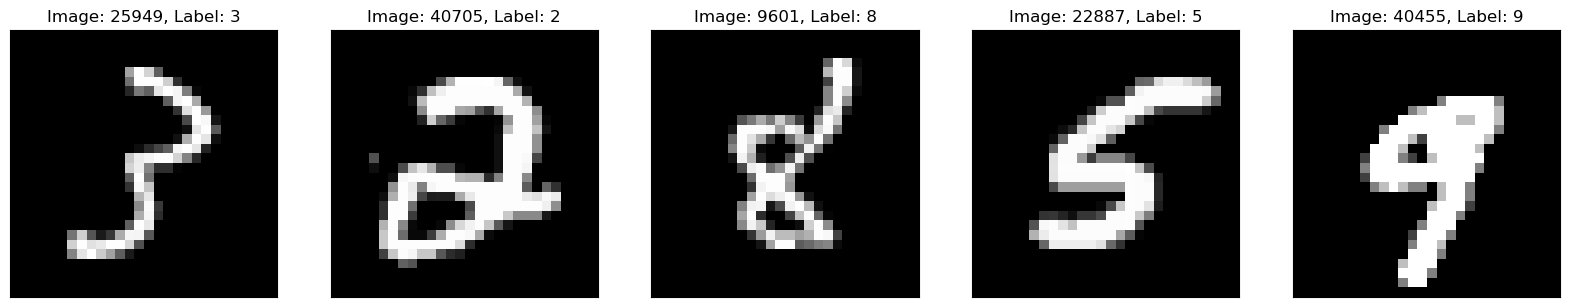

In [18]:
num_images = 5
ith_image = np.random.randint(low=0, high=train_set.data.shape[0], size=num_images)

fig, axs = plt.subplots(1,5, figsize=(20,4))

for i in np.arange(num_images):
    axs[i].tick_params(labelbottom=False,bottom=False,labelleft=False,left=False)
    axs[i].imshow(train_set.data[ith_image[i]],cmap='gray')
    axs[i].set_title(f"Image: {ith_image[i]}, Label: {train_set.targets[ith_image[i]]}")

## Classification Using Autoencoder

### Use Dataloader for to Make Batches

In [19]:
training_loader = DataLoader(train_set, batch_size=64)
validation_loader = DataLoader(test_set, batch_size=64)

### Load Model

In [28]:
from Model import Autoencoder

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encode1): Linear(in_features=784, out_features=1000, bias=True)
  (encode2): Linear(in_features=1000, out_features=500, bias=True)
  (encode3): Linear(in_features=500, out_features=250, bias=True)
  (encode4): Linear(in_features=250, out_features=2, bias=True)
  (decode4): Linear(in_features=2, out_features=250, bias=True)
  (decode3): Linear(in_features=250, out_features=500, bias=True)
  (decode2): Linear(in_features=500, out_features=1000, bias=True)
  (decode1): Linear(in_features=1000, out_features=784, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(28, 28))
)


### Define Loss and Optimizer

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Train

In [31]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [32]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>